# PyTorch Tutorial Series

[pytorch3](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Tutorial%20Series/pytorch3.ipynb)

In [19]:
%reset -sf

In [20]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt

## Machine Learning Summary

Suppose one has data that consists of an independent vector and a dependent vector $x_i$  and $y_i$ ($i$ is the ith value in the data set). For example:

- $x_i$ is the height of the $i$th person, and $y_i$ is their weight (predict weight using height)
- $x_i$ is a picture of a handwritten digit, and $y_i$ is the digit itself (predict numbers from hand written numbers)
- $x_i$ is a CT scan of a patient, and $y_i$ are the corresponding pixels corresponding to tumours (my research)

The goal of a neural network is as follows. Define a function $f$ that depends on parameters $a$ that makes predictions

$$
\hat{y}_i=f(x_i;a)
$$

One wants to make $\hat{y}_i$ (the predictions) and $y_i$ (the true values) as close as possible by modifying the values of $a$. What does as close as possible mean? This depends on the task. In general, one defines a similarity function $L(y,\hat{y})$ (or **Loss** function) 
. The more similar all the $\hat{y}_i$s and $y_i$s are, the smaller $L$ should be. For example 1 above, this could be as simple as

$$
L(y,\hat{y})=\sum_i(y_i-\hat{y}_i)^2
$$
 
## Last Video

Given 4 data points $(x_i, y_i)$ and wanted to find a function $f$ such that $f(x_i)=y_i$. Since each $x_i$ was a vector of length $2$, we chose the function
$$
f(x)=A_2A_1x
$$
where $A_1$ is a $8 \times 2$  matrix and $A_2$ is a $1 \times 8$ matrix. This means there were  $16+8$ free parameters. This simple function did not do a very good job of making $f(x_i)=y_i$.

In [21]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()
    
f = MyNeuralNet()
opt = SGD(f.parameters(), lr=0.001)
L = nn.MSELoss()

# Train model
losses = []
for _ in range(50):
    opt.zero_grad() # flush previous epoch's gradient
    loss_value = L(f(x), y) #compute loss
    loss_value.backward() # compute gradient
    opt.step() # Perform iteration using gradient above
    losses.append(loss_value.item())

In [22]:
y

tensor([1., 5., 2., 5.])

In [23]:
f(x)

tensor([3.4576, 2.9328, 0.9876, 4.5995], grad_fn=<SqueezeBackward0>)

## This Video

As it turns out, our previous model was not very good at all. In fact, although there were 24 parameters in the **two** matrices, there was technically only two independent parameters. This is because
$$
A_2A_1=B
$$
where $B$ is a $2 \times 1$  matrix. So really our function was $f(x)=Bx$

### How can we use this simplicity of linear algebra but have advanced models?

**The Crux of Machine Learning**: This lies in so-called activation functions, which add ever-so-slight non-linearities to a sequence of matrix transformations. Instead of the transformation
$$
\begin{array}{rc} \mbox{Old Model:} & f(x)=A_2A_1x \end{array}
$$

consider instead
$$
\begin{array}{rc} \mbox{New Model:} & f_2(x)=A_2R(A_1x)  \end{array}
$$

where $R$ is an element-wise operator defined by
$$
R(x)=
\left\{ \begin{aligned} 
 x &\quad x \gt 0\\
 0 &\quad x \leq 0 
\end{aligned} \right.
$$
 
So $R$ is the identity function if $x \gt 0$ but sets values equal to zero if $x$ is less than zero. This is **so-close** to being a linear operator, but it is not.

In [24]:
x = torch.tensor([[4,6,2,-1,6,2,5],[1,6,2,-6,5,-3,5]])
x

tensor([[ 4,  6,  2, -1,  6,  2,  5],
        [ 1,  6,  2, -6,  5, -3,  5]])

In [25]:
R = nn.ReLU()
R(x)

tensor([[4, 6, 2, 0, 6, 2, 5],
        [1, 6, 2, 0, 5, 0, 5]])

Another example

In [26]:
x = torch.linspace(-3,3,100)
y = R(x)

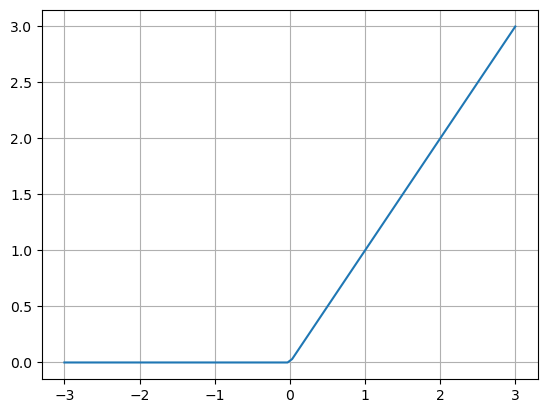

In [27]:
plt.plot(x.numpy(), y.numpy())
plt.grid()
plt.show()

How much better does our model do with this simple adjustment?

In [28]:
class MyNeuralNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

Train model (lets write a function to do this, since we'll be doing it a lot)

In [29]:
def train_model(x,y,f, n_epochs=50):
    opt = SGD(f.parameters(), lr=0.001)
    L = nn.MSELoss()

    # Train model
    losses = []
    for _ in range(n_epochs):
        opt.zero_grad() # flush previous epoch's gradient
        loss_value = L(f(x), y) #compute loss
        loss_value.backward() # compute gradient
        opt.step() # Perform iteration using gradient above
        losses.append(loss_value.item())
    return f, losses

In [30]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f2 = MyNeuralNet2()

# Train model
f2, losses2 = train_model(x,y,f2, n_epochs=5000)

Now lets look at the predictions:

In [31]:
y

tensor([1., 5., 2., 5.])

In [32]:
f(x)

tensor([3.4576, 2.9328, 0.9876, 4.5995], grad_fn=<SqueezeBackward0>)

Slightly better. But the real advantage of this slight non-linearity is that we can make our matrices much larger. Lets make our matrices size $80 \times 2$ and $1 \times 80$. This **only** works because of our non-linearity function $R(x)$ :

- Without $R(x)$ , we would just have $A_2A_1 = B$ and so $f(x)=Bx$  where $B$ is still a $1 \times 2$ matrix even though $A_2$ and $A_1$ are larger matrices. The non-linearity function $R(x)$ , to some extent, makes all 240 parameters more independent from each other.

$$
\begin{array}{rll} 
\mbox{Old Model:}  &f_2(x)=A_2R(A_1x) & A_2 \mbox{ is } 1 \times 8 \mbox{ and } A_1 \mbox{ is } 8 \times 2\\
\mbox{New Model:} &f_3(x)=A_2R(A_1x) & A_2 \mbox{ is } 1 \times 80 \mbox{ and } A_1 \mbox{ is } 80 \times 2
\end{array}
$$


In [33]:
class MyNeuralNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80, bias=False)
        self.Matrix2 = nn.Linear(80,1, bias=False)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

Train model:

In [34]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f3 = MyNeuralNet3()

# Train model
f3, losses3 = train_model(x,y,f3, n_epochs=5000)

In [35]:
y

tensor([1., 5., 2., 5.])

In [36]:
f3(x)

tensor([1.4833, 4.3151, 1.9545, 5.0763], grad_fn=<SqueezeBackward0>)

Closer, but still not exact. We can make our model better by introducing other parameters:
$$
f(x)=A_2R(A_1x+b_1)+b_2
$$

where $b_1$ and $b_2$ are vectors added to each of the linear transformations.
$$
\begin{array}{rll} 
\mbox{Old Model:}  &f_3(x)=A_2R(A_1x) & A_2 \mbox{ is } 1\times80 \mbox{ and } A_1 \mbox{ is } 80\times2\\
\mbox{New Model:} &f_4(x)=A_2R(A_1x+b_1)+b_2 & A_2 \mbox{ is } 1 \times 80 \mbox{ and } A_1 \mbox{ is } 80 \times 2
\end{array}
$$

In [37]:
class MyNeuralNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80)
        self.Matrix2 = nn.Linear(80,1)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

In [38]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f4 = MyNeuralNet4()

# Train model
f4, losses4 = train_model(x,y,f4, n_epochs=5000)

In [39]:
y

tensor([1., 5., 2., 5.])

In [40]:
f4(x)

tensor([1.8272, 4.0112, 2.0714, 4.9982], grad_fn=<SqueezeBackward0>)

Better, but its still not getting us that close to $y$, however. What if we add another matrix in the middle?
$$
\begin{array}{rll} 
\mbox{Old Model:}  &f_4(x)=A_2R(A_1x+b_1)+b_2 & A_2 \mbox{ is } 1\times80 \mbox{ and } A_1 \mbox{ is } 80\times2\\
\mbox{New Model:} &f_5(x)=A_3R(A_2R(A_1x+b_1)+b_2) & A_3 \mbox{ is } 1 \times 80 \mbox{ and } A_2 \mbox{ is } 80 \times 80 \mbox{ and } A_1 \mbox{ is } 80 \times 2
\end{array}
$$

In [41]:
class MyNeuralNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80)
        self.Matrix2 = nn.Linear(80,80)
        self.Matrix3 = nn.Linear(80,1)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f5 = MyNeuralNet5()

# Train model
f5, losses5 = train_model(x,y,f5, n_epochs=5000)

In [42]:
y

tensor([1., 5., 2., 5.])

In [43]:
f5(x)

tensor([1.0010, 4.9989, 2.0000, 5.0001], grad_fn=<SqueezeBackward0>)

Its predicting $y$ almost exactly (albeit by overfitting, no doubt, but the message here is that the model has the potential to fit to these arbitrary data points, through a sequence of **linear** transofmrations followed by slightly non-linear )

## The "Sequential" Neural Network

A general "sequential" neural network can be expressed as
$$
f(x)=\mathop{\Large{\kappa}}\limits_{i=1}^{n}R_i(A_ix+b_i)
$$
where $\mathop{\Large{\kappa}}\limits_{i=1}^{n}f_i(x)=f_n \circ f_{n-1}\ldots \circ f_1(x)$ and the $A_i$ are matrices and the $b_i$ are bias vectors. Typically the $R_i$ are the same for all the layers (typically ReLU) **except** for the last layer, where $R_i$ is just is just the identity function

- **Note**: In clever architectures, like convolutional neural networks, the $A_i$'s become sparse matrices (most of there parameters are fixed to equal zero).